In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as ip


To-do:

1. In the final plot, predict from interpolated temp and pres data and see how they perform
2. Change the scaling into functions. Create unscaling functions as well
3. See if you can model the curve better (the peaks in the plot)
4. Add time into the neural network as an input

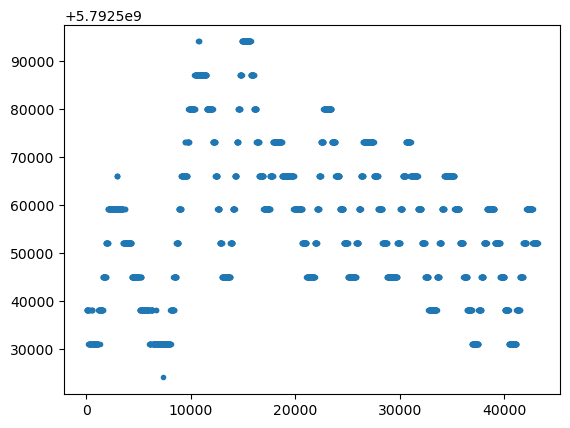

In [9]:
freq_raw = pd.read_csv('freq_overnight_053024.csv')

freq_raw['Time(s)'] = freq_raw['Time (hr)']*3600
#print(freq_raw['Frequency (Hz)'])
plt.plot(freq_raw['Time(s)'], freq_raw['Frequency (Hz)'], '.')

25444


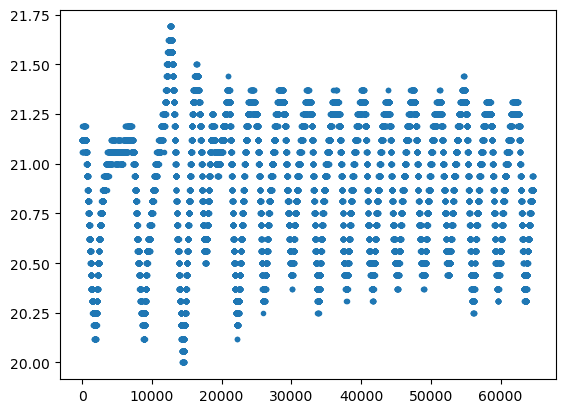

In [10]:
temp_pres_raw = pd.read_csv('05_30_24_overnight_temp_pressure.csv')
#print(temp_pres_raw.iloc[[1000]])
plt.plot( temp_pres_raw['Time(s)'], temp_pres_raw['Temp(*C)'], '.')
print(len(temp_pres_raw['Temp(*C)']))

25444


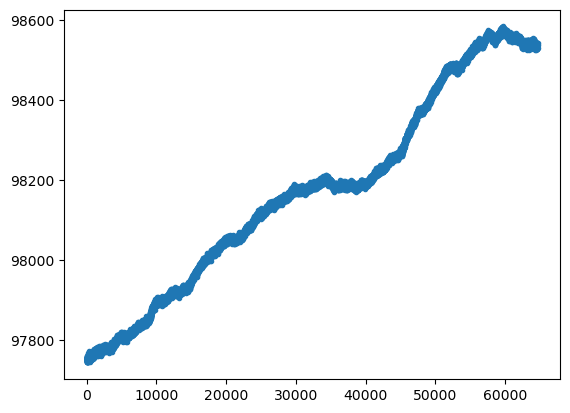

In [11]:
plt.plot( temp_pres_raw['Time(s)'], temp_pres_raw['Pressure(Pa)'], '.')
print(len(temp_pres_raw['Pressure(Pa)']))

# Interpolating Frequency

In [12]:
freq_time = np.array(freq_raw['Time(s)'], dtype='float64')
freq_data = np.array(freq_raw['Frequency (Hz)'], dtype='float64')

temp_pres_time = np.array(temp_pres_raw['Time(s)'], dtype='float64')
temp_data = np.array(temp_pres_raw['Temp(*C)'], dtype='float64')
pres_data = np.array(temp_pres_raw['Pressure(Pa)'], dtype='float64')

In [13]:
flimit = np.ix_(temp_pres_time <= freq_time[-1])[0].shape[0]
print(flimit)

f = ip.CubicSpline(freq_time, freq_data - freq_data.min(), bc_type='natural')
y_new = f(temp_pres_time[:flimit])


17001


# Data Processing and Scaling

In [14]:
# Create min subtracted data sets for temp, pres and freq
freq_var = y_new[50:] - y_new[50:].min()
temp_var = temp_data[50:flimit] - temp_data[50:flimit].min()
pres_var = pres_data[50:flimit] - pres_data[50:flimit].min()
print(freq_var.shape[0], temp_var.shape[0], pres_var.shape[0])

16951 16951 16951


In [15]:
# Scale temp and pres data into the interval [0, 1], freq data in [0, 10]; min-max scaling

t_min = temp_pres_time[50:flimit].min()
t_max = temp_pres_time[50:flimit].max()
scaled_time = (temp_pres_time[50:flimit] - t_min) / (t_max - t_min)
f_min = freq_var.min()
f_max = freq_var.max()
scaled_freq = 10.0 * (freq_var - f_min) / (f_max - f_min)
p_min = pres_var.min()
p_max = pres_var.max()
scaled_pres = (pres_var - p_min) / (p_max - p_min)
k_min = temp_var.min()
k_max = temp_var.max()
scaled_temp = (temp_var - k_min) / (k_max - k_min)

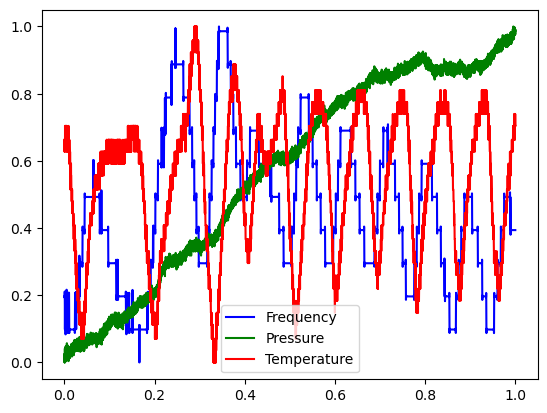

In [16]:
plt.plot(scaled_time, scaled_freq/10, 'b-', label = 'Frequency')
plt.plot(scaled_time, scaled_pres, 'g-', label = 'Pressure')
plt.plot(scaled_time, scaled_temp, 'r-', label = 'Temperature')
plt.legend()

# Neural Network

In [17]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, InputLayer

In [18]:
data_nn = pd.DataFrame()
data_nn['Freq'] = scaled_freq
data_nn['Pressure'] = scaled_pres
data_nn['Temp'] = scaled_temp

x = data_nn.drop('Freq', axis=1)
y = data_nn['Freq']
print(data_nn)

           Freq  Pressure      Temp
0      1.970299  0.021739  0.662722
1      1.974400  0.015810  0.662722
2      1.977289  0.025692  0.627219
3      1.977196  0.017787  0.662722
4      1.972352  0.009881  0.662722
...         ...       ...       ...
16946  3.940054  0.986166  0.739645
16947  3.940054  0.982213  0.704142
16948  3.940054  0.976285  0.704142
16949  3.940054  0.978261  0.704142
16950  3.940054  0.988142  0.704142

[16951 rows x 3 columns]


In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=64, shuffle=True)
#print(X_train, y_test)

In [20]:
#X_train = x_train[:,:2]
#X_test = x_test[:,:2]
print(x_train, x_test, y_test)

       Pressure      Temp
13378  0.901186  0.260355
8345   0.610672  0.662722
7940   0.608696  0.662722
9846   0.733202  0.662722
9772   0.754941  0.739645
...         ...       ...
7987   0.610672  0.739645
9201   0.671937  0.662722
16438  0.942688  0.295858
3238   0.203557  0.218935
6596   0.513834  0.739645

[13560 rows x 2 columns]        Pressure      Temp
4652   0.330040  0.775148
3275   0.209486  0.183432
9054   0.664032  0.479290
8057   0.618577  0.739645
5443   0.369565  0.260355
...         ...       ...
13182  0.893281  0.260355
15788  0.875494  0.775148
10108  0.764822  0.295858
4870   0.351779  0.958580
10410  0.782609  0.331361

[3391 rows x 2 columns] 4652     7.885554
3275     2.953539
9054     7.885555
8057     4.933761
5443     3.963347
           ...   
13182    2.953557
15788    1.967304
10108    4.028746
4870     5.905518
10410    6.899135
Name: Freq, Length: 3391, dtype: float64


In [22]:
opt = SGD(learning_rate = 0.005)
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=opt)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                192       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,001
Trainable params: 4,001
Non-traina

In [23]:
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
424/424 [==============================] - 3s 6ms/step - loss: 5.5146 - val_loss: 4.5267
Epoch 2/200
424/424 [==============================] - 2s 4ms/step - loss: 3.9236 - val_loss: 3.6296
Epoch 3/200
424/424 [==============================] - 2s 4ms/step - loss: 3.0647 - val_loss: 2.8206
Epoch 4/200
424/424 [==============================] - 2s 5ms/step - loss: 2.8343 - val_loss: 3.1113
Epoch 5/200
424/424 [==============================] - 2s 6ms/step - loss: 2.7316 - val_loss: 2.7869
Epoch 6/200
424/424 [==============================] - 3s 7ms/step - loss: 2.6653 - val_loss: 3.2585
Epoch 7/200
424/424 [==============================] - 4s 8ms/step - loss: 2.6074 - val_loss: 2.8731
Epoch 8/200
424/424 [==============================] - 4s 8ms/step - loss: 2.5493 - val_loss: 2.4647
Epoch 9/200
424/424 [==============================] - 3s 8ms/step - loss: 2.5077 - val_loss: 2.3969
Epoch 10/200
424/424 [==============================] - 3s 8ms/step - loss: 2.4516 - val_lo

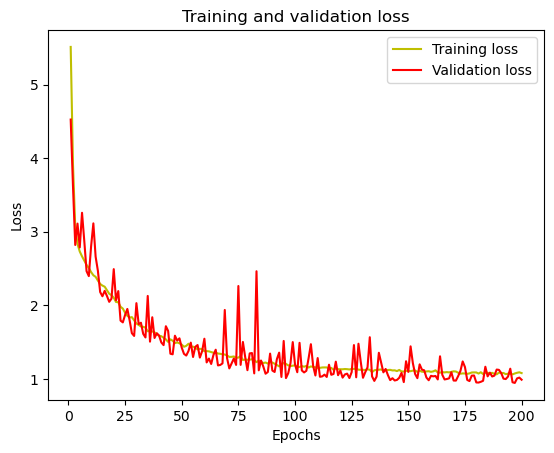

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

530/530 [==============================] - 2s 3ms/step


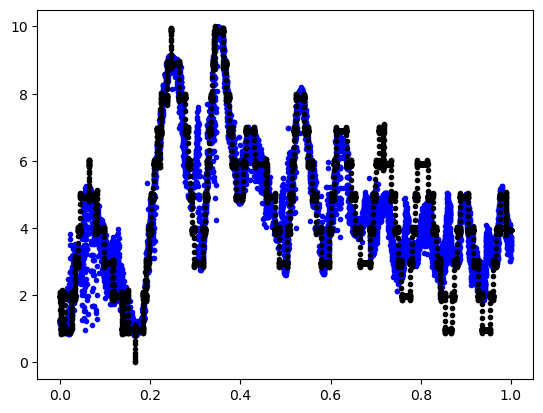

In [32]:
prediction_test = model.predict(x)    

plt.plot(scaled_time, prediction_test, 'b.')
plt.plot(scaled_time, scaled_freq, 'k.')
plt.show()

In [ ]:
#freq_pred = model.predict(scaler.transform(x_transformed))
